In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.split(os.getcwd())[0])

In [3]:
import torch
from PIL import Image
from tqdm.auto import tqdm

In [4]:
from network import load_model
import utils

In [5]:
cf = utils.Config('../config/1flow.yaml')
cf.device = 'cpu'

model = load_model(cf.model)

In [6]:
checkpoint = torch.load('../checkpoint/model_1flow_0.925.pt', map_location = 'cpu')
checkpoint_model = {k[7:]:v for k, v in checkpoint['model'].items()}
model.load_state_dict(checkpoint_model)
model.eval()
print('load state dict')

load state dict


In [11]:
from data.transform import to_tensor
import pandas as pd
from data.model_dataset import FontDataset
from torch.utils.data import DataLoader

val_df = pd.read_csv('../data/val_pair_font_all.csv')
val_data = FontDataset('../../dataset/font_images_all', val_df.sample_1, val_df.sample_2, val_df.labels, to_tensor)
# val_loader = DataLoader(val_data, batch_size = 8, shuffle = False)

In [18]:
device = 'cpu'
predict_label = []
gt_label = []
with torch.no_grad():
    val_loss, val_accuracy = 0.0, 0.0
    for i in tqdm(range(len(val_data))):
        img_1, img_2, labels = val_data[i]

        outputs = model(img_1.unsqueeze(0), img_2.unsqueeze(0))
        y_predict = torch.softmax(outputs, dim = 1).argmax(dim = 1)
        predict_label.append(y_predict.item())
        
        val_accuracy += torch.sum(y_predict == labels).item()
        
    val_accuracy /= len(val_data)

  0%|          | 0/44604 [00:00<?, ?it/s]

/home/pqhuy/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [23]:
with open('./predict_label.txt', 'w') as f:
    f.write('\t'.join([str(i) for i in predict_label]))

## report

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
val_df = pd.read_csv('../data/val_pair_font_all.csv')
with open('./predict_label.txt') as f:
    predict_label = [int(i) for i in f.read().split('\t')]

In [11]:
confusion_matrix(val_df.labels, predict_label)

array([[20668,  1634],
       [ 1708, 20594]])

In [12]:
print(classification_report(val_df.labels, predict_label))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     22302
           1       0.93      0.92      0.92     22302

    accuracy                           0.93     44604
   macro avg       0.93      0.93      0.93     44604
weighted avg       0.93      0.93      0.93     44604



In [24]:
false_df = val_df[val_df.labels != predict_label]

In [29]:
diff = {}
for sample_1, sample_2, label in false_df.values:
    c1 = sample_1.split('/')[-1][0]
    c2 = sample_2.split('/')[-1][0]
    diff[f'{c1}_{c2}'] = 1 + diff.get(f'{c1}_{c2}', 0)

In [37]:
max(diff, key = diff.get), diff['7_y']

('7_y', 7)

In [38]:
words = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [42]:
img = np.zeros((len(words), len(words)))
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
for s1 in words:
    for s2 in words:
        i = words.index(s1)
        j = words.index(s2)
        img[i, j] += diff.get(f'{s1}_{s2}', 0)

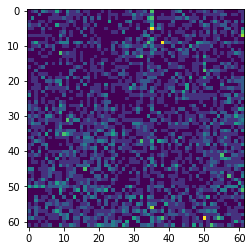

In [48]:
plt.imshow(img)